# Srovnání komprese dat pomocí SVD a waveletů

In [456]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import pywt
import time


Načtení obrazu a nastavení poměru dat
1 Obraz - tráva
2 Obraz - vzor
3 Obraz - malba

In [478]:

image_noice = np.copy(cv.imread('data/grass_noice.jpg', cv.IMREAD_GRAYSCALE).astype(np.float64()))
image_pattern = np.copy(cv.imread('data/image-pattern.jpg', cv.IMREAD_GRAYSCALE).astype(np.float64()))
image_normal = np.copy(cv.imread('data/paitning_normal.jpg', cv.IMREAD_GRAYSCALE).astype(np.float64()))

N = 6 # počet různých kompresních poměrů

keep_ratios = np.linspace(0.05, 0.5, N)
image_names = ['Noice Image', 'Pattern Image', 'Normal Image']
original_images = [image_noice, image_pattern, image_normal]

Funkce pro výpočet PSNR mezi originálním obrazem a po kompresi

In [479]:

def PSNR (I1, I2):
    mse = np.mean((I1 - I2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

# SVD 

In [480]:
#komprese
def svd_compress(image, k):
    U, S, VT = np.linalg.svd(image, full_matrices=False)
    return U[:, :k], S[:k], VT[:k, :]
#dekomprese
def svd_reconstruct(Uk, Sk, VTk):
    return Uk @ np.diag(Sk) @ VTk

# Vypočet uložených hodnot pro SVD kompresi
def svd_storage(m, n, k):
    return k * (m + n + 1)


# Inicializace výsledných seznamů
reconstructed_images_SVD = []
PSNR_SVD = []
k_values = []
compression_ratios_svd = []
compress_time_svd = []
decompress_time_svd = []
# Zpracování každého obrázku
for image in original_images:
    m, n = image.shape
    original_size = m * n
    print("\nProcessing new image:")
    # Zpracování každého poměru uložení
    for ratio in keep_ratios:
        # Výpočet hodnoty k
        targeted_size = original_size * ratio
        k = int((targeted_size) / (m + n + 1))
        k_values.append(k)
        # SVD komprese
        start_time = time.time()

        Uk, Sk, VTk = svd_compress(image, k)

        end_time = time.time()
        compression_time = end_time - start_time
        compress_time_svd.append(compression_time)
        # SVD dekomprese
        start_time = time.time()

        A_k = svd_reconstruct(Uk, Sk, VTk)

        end_time = time.time()
        decompression_time = end_time - start_time
        decompress_time_svd.append(decompression_time)

        reconstructed_images_SVD.append(A_k)
        # Výpočet kompresního poměru a PSNR
        compression_ratios_svd.append(original_size / (k * (m+n+1)))
        stored = svd_storage(m, n, k)
        psnr = PSNR(image, A_k)
        PSNR_SVD.append(psnr)
        print(f"k={k:3} | Stored values={stored} | Keep ratio={ratio:.2f}x | Compression ratio={compression_ratios_svd[-1]:.2f}x | PSNR={psnr:.2f} dB")

# Průměrný čas SVD komprese a dekomprese
average_compression_time_svd = np.mean(compress_time_svd)
average_decompression_time_svd = np.mean(decompress_time_svd)
print(f"Průměrný SVD čas komprese: {average_compression_time_svd:.64} s")
print(f"Průměrný SVD čas dekomprese: {average_decompression_time_svd:.4f} s")



Processing new image:
k= 32 | Stored values=84032 | Keep ratio=0.05x | Compression ratio=20.08x | PSNR=16.27 dB
k= 89 | Stored values=233714 | Keep ratio=0.14x | Compression ratio=7.22x | PSNR=20.14 dB
k=147 | Stored values=386022 | Keep ratio=0.23x | Compression ratio=4.37x | PSNR=23.03 dB
k=205 | Stored values=538330 | Keep ratio=0.32x | Compression ratio=3.13x | PSNR=25.35 dB
k=263 | Stored values=690638 | Keep ratio=0.41x | Compression ratio=2.44x | PSNR=27.38 dB
k=321 | Stored values=842946 | Keep ratio=0.50x | Compression ratio=2.00x | PSNR=29.31 dB

Processing new image:
k= 35 | Stored values=105035 | Keep ratio=0.05x | Compression ratio=20.56x | PSNR=21.70 dB
k=100 | Stored values=300100 | Keep ratio=0.14x | Compression ratio=7.20x | PSNR=26.15 dB
k=165 | Stored values=495165 | Keep ratio=0.23x | Compression ratio=4.36x | PSNR=29.97 dB
k=230 | Stored values=690230 | Keep ratio=0.32x | Compression ratio=3.13x | PSNR=33.45 dB
k=295 | Stored values=885295 | Keep ratio=0.41x | Com

Vykreslení originálu a obrázku po dekompresi

# WAVELET

In [481]:
# Komprese 
def wavelet_compress_by_budget(image, level, wavelet, keep_ratio):
    # Vypočet koeficientů waveletovy transformace
    coeffs = pywt.wavedec2(image, wavelet=wavelet, level=level)
    coeffs_array, coeff_slices = pywt.coeffs_to_array(coeffs)
    # Tvarování do 1D pole pro snadnou manipulaci
    flat = coeffs_array.ravel()
    # Určení počtu koeficientů k ponechání
    n_total = flat.size
    n_keep = int(n_total * keep_ratio)
    # Získání indexů největších koeficientů
    idx = np.argsort(np.abs(flat))
    mask = np.zeros_like(flat, dtype=bool)
    mask[idx[-n_keep:]] = True
    # Vytvoření nového pole s ponechanými koeficienty
    flat_compressed = np.zeros_like(flat)
    flat_compressed[mask] = flat[mask]
    # Reshape zpět do původního tvaru
    coeffs_array_compressed = flat_compressed.reshape(coeffs_array.shape)

    return coeffs_array_compressed, coeff_slices

# Dekomprese z pole koeficientů
def wavelet_reconstruct_from_array(coeffs_array, coeff_slices, wavelet, original_shape=None):
    coeffs = pywt.array_to_coeffs(coeffs_array, coeff_slices, output_format='wavedec2')

    rec = pywt.waverec2(coeffs, wavelet)

    # Oříznutí na původní velikost, protože při lichém rozměru dojde k zvětšení obrázku
    rec_cropped = rec[:original_shape[0], :original_shape[1]]
    return rec_cropped

# Počet nenulových koeficientů
def count_nonzero_coeffs(coeffs):
    count = np.count_nonzero(coeffs)
    return count

# Inicializace výsledných seznamů
level = 2
reconstructed_images_wavelet = []
PSNR_Wavelet = []
compression_ratios_wavelet = []
compress_time_wavelet = []
decompress_time_wavelet = []

# Zpracování každého obrázku
for image in original_images:
    print("\nProcessing new image:")
    original_size = image.size
    # Zpracování každého poměru uložení
    for ratios in keep_ratios:
        # Wavelet komprese
        start_time = time.time()

        coeffs_array_compressed, coeff_slices = wavelet_compress_by_budget(image, level=level, wavelet='db1', keep_ratio=ratios)

        end_time = time.time()
        compression_time = end_time - start_time
        compress_time_wavelet.append(compression_time)
        # Wavelet dekomprese
        start_time = time.time()

        Image_T = wavelet_reconstruct_from_array(coeffs_array_compressed, coeff_slices, wavelet='db1', original_shape=image.shape)

        end_time = time.time()
        decompression_time = end_time - start_time
        decompress_time_wavelet.append(decompression_time)


        reconstructed_images_wavelet.append(Image_T)
        # Výpočet kompresního poměru a PSNR
        nonzero = count_nonzero_coeffs(coeffs_array_compressed)
        total_coeffs = coeffs_array_compressed.size
        compression_ratios_wavelet.append(total_coeffs / nonzero)
        # Uložení prahu
        psnr = PSNR(image, Image_T)
        PSNR_Wavelet.append(psnr)
        print(f"Keep ratio={ratios:.2f} | Non-zero coeffs= {nonzero} | "
              f"Compression ratio={compression_ratios_wavelet[-1]:.2f}x | PSNR={psnr:.2f} dB")

# Průměrný čas Wavelet komprese a dekomprese
average_compression_time_wavelet = np.mean(compress_time_wavelet)
average_decompression_time_wavelet = np.mean(decompress_time_wavelet)
print(f"Průměrný Wavelet čas komprese: {average_compression_time_wavelet:.6f} s")
print(f"Průměrný Wavelet čas dekomprese: {average_decompression_time_wavelet:.6f} s")



Processing new image:
Keep ratio=0.05 | Non-zero coeffs= 84525 | Compression ratio=20.00x | PSNR=19.13 dB
Keep ratio=0.14 | Non-zero coeffs= 236670 | Compression ratio=7.14x | PSNR=26.72 dB
Keep ratio=0.23 | Non-zero coeffs= 388814 | Compression ratio=4.35x | PSNR=30.80 dB
Keep ratio=0.32 | Non-zero coeffs= 540960 | Compression ratio=3.12x | PSNR=34.33 dB
Keep ratio=0.41 | Non-zero coeffs= 693105 | Compression ratio=2.44x | PSNR=37.76 dB
Keep ratio=0.50 | Non-zero coeffs= 845250 | Compression ratio=2.00x | PSNR=41.34 dB

Processing new image:
Keep ratio=0.05 | Non-zero coeffs= 108000 | Compression ratio=20.00x | PSNR=20.70 dB
Keep ratio=0.14 | Non-zero coeffs= 302400 | Compression ratio=7.14x | PSNR=45.31 dB
Keep ratio=0.23 | Non-zero coeffs= 496799 | Compression ratio=4.35x | PSNR=55.59 dB
Keep ratio=0.32 | Non-zero coeffs= 691200 | Compression ratio=3.12x | PSNR=62.64 dB
Keep ratio=0.41 | Non-zero coeffs= 885600 | Compression ratio=2.44x | PSNR=78.84 dB
Keep ratio=0.50 | Non-zero co

Vykreslení originálu a porovnání obou metod

3


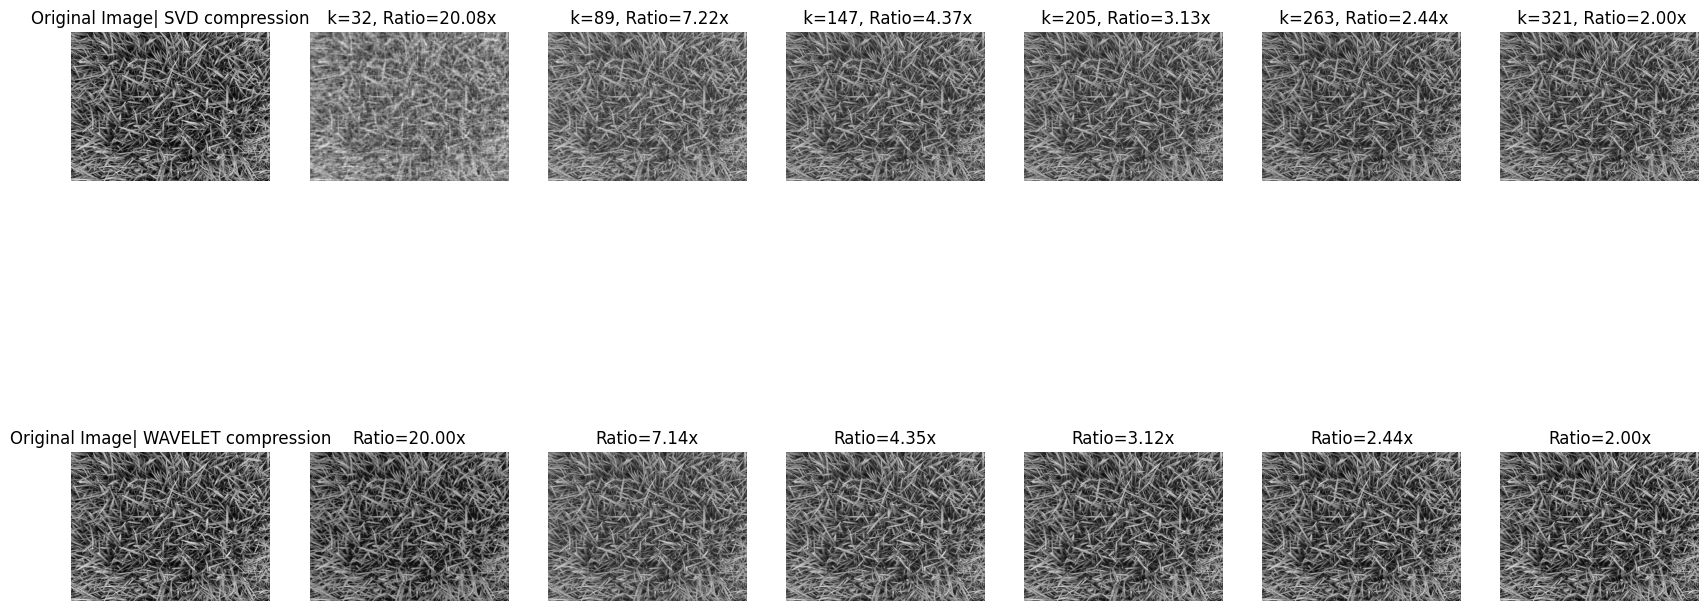

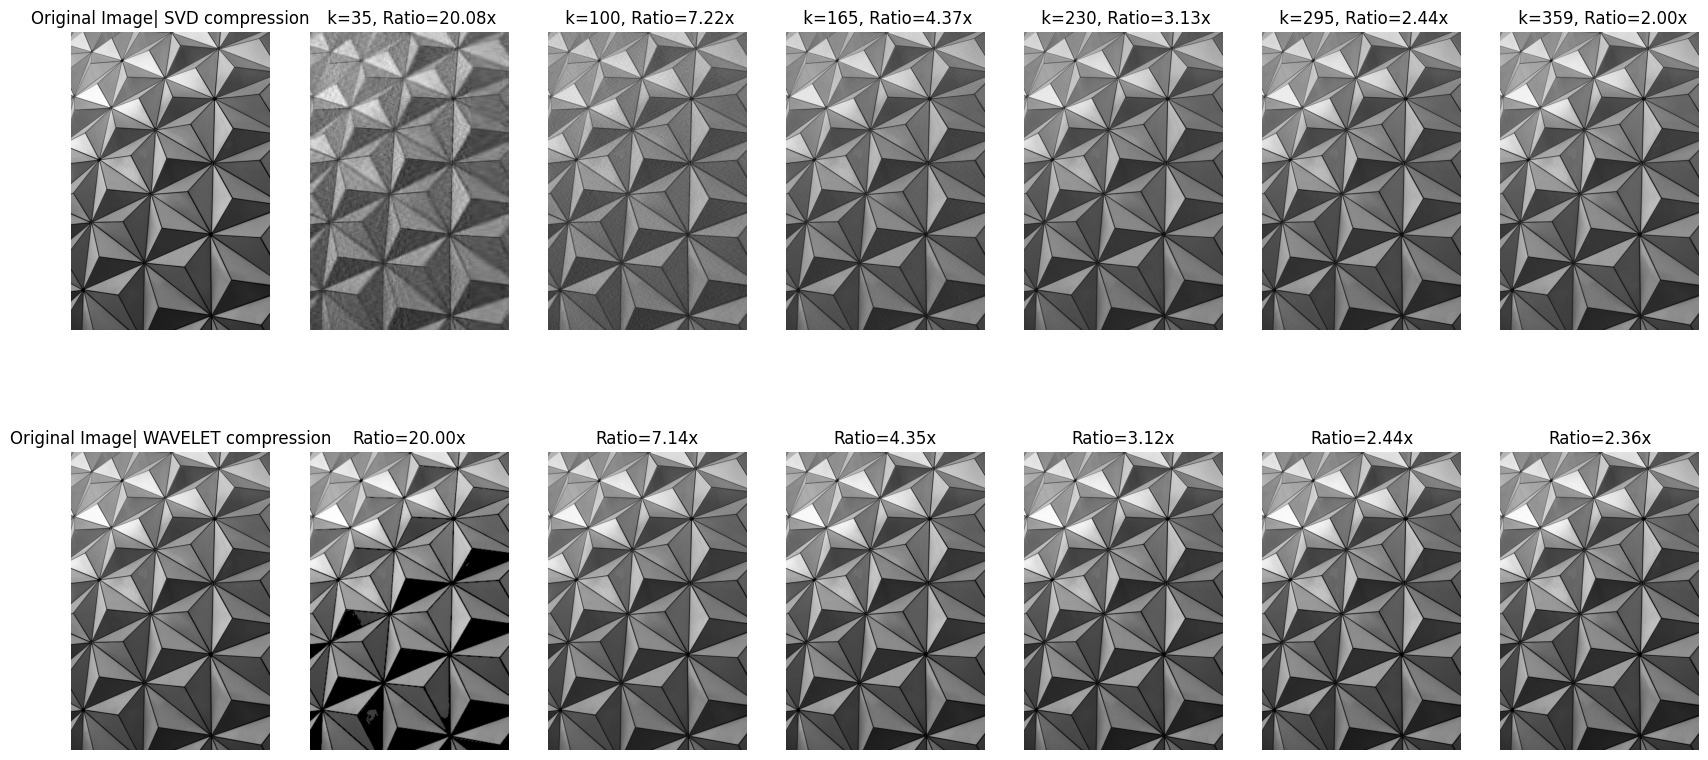

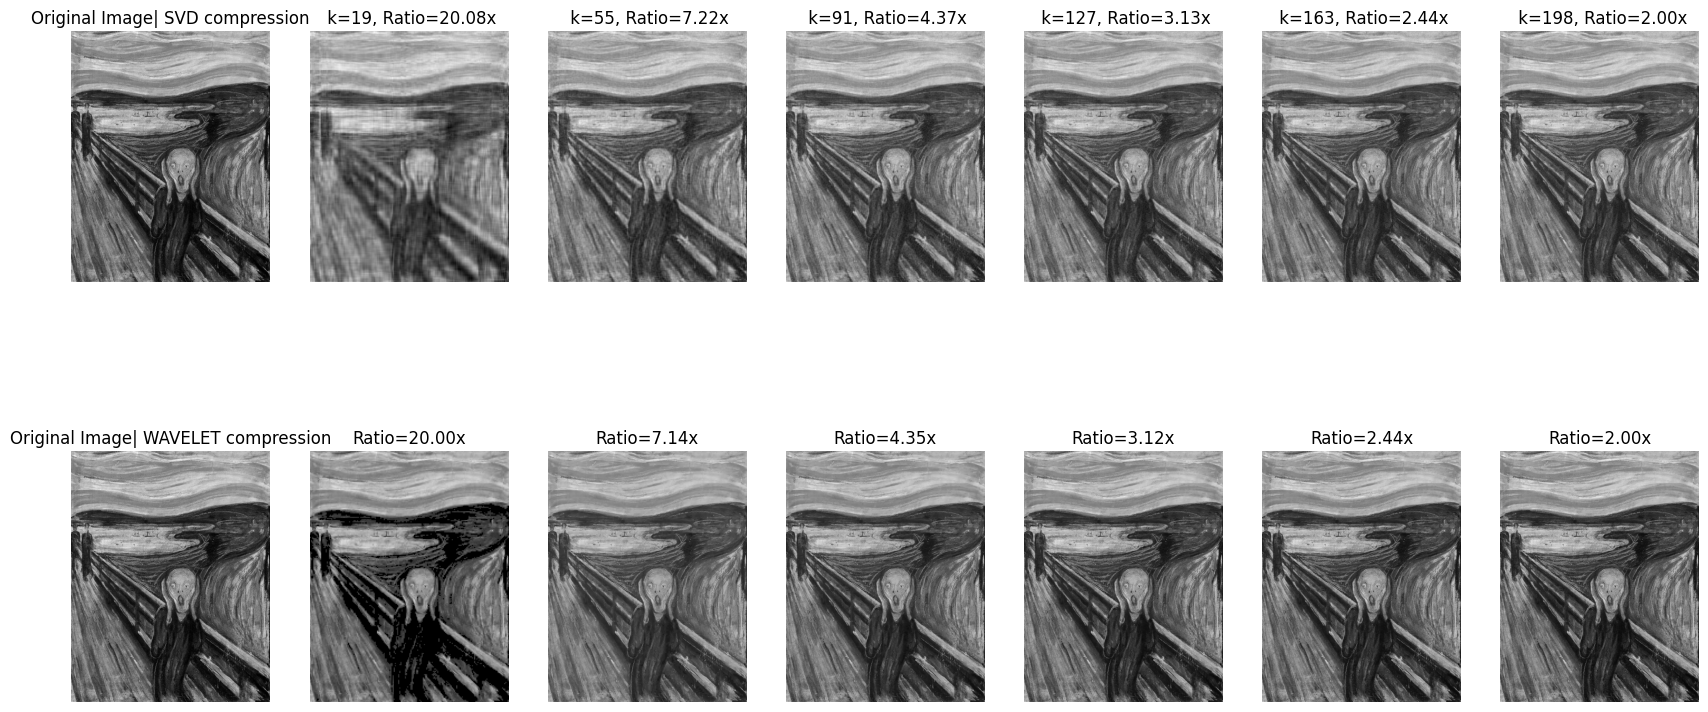

In [482]:
cols = len(reconstructed_images_wavelet) // len(original_images) + 1
print(len(original_images))

for img_idx, image in enumerate(original_images):
    # Vytvoření figure a axes
    fig, axes = plt.subplots(2, cols, figsize=(cols * 3, 10))
    for n in range(2):
    # Originál
        axes[n, 0].imshow(image, cmap='gray')
        axes[n, 0].set_title('Original Image| SVD compression' if n == 0 else 'Original Image| WAVELET compression')
        axes[n, 0].axis('off')

    start = img_idx * (cols - 1)
    # Vykreselení SVD dekomprese obrazu
    for i, A_K in enumerate(reconstructed_images_SVD[start:start + (cols - 1)]):
        axes[0, i + 1 ].imshow(A_K, cmap='gray')
        axes[0, i + 1 ].set_title(f' k={k_values[start + i]}, Ratio={compression_ratios_svd[i]:.2f}x')
        axes[0, i + 1 ].axis('off')
    # Vykreselení WAVELET dekomprese obrazu
    for i, A_k in enumerate(reconstructed_images_wavelet[start:start + (cols - 1)]):
        axes[1, i + 1].imshow(A_k, cmap='gray')
        axes[1, i + 1].set_title(f'Ratio={compression_ratios_wavelet[start + i]:.2f}x')
        axes[1, i + 1].axis('off')

    # Uložení obrázku
    fig.savefig(f'results/{image_names[img_idx]}_kompresion.png', bbox_inches='tight')
    plt.show()

# Vykreslení výsledků porovnání SVD a Wavelet komprese

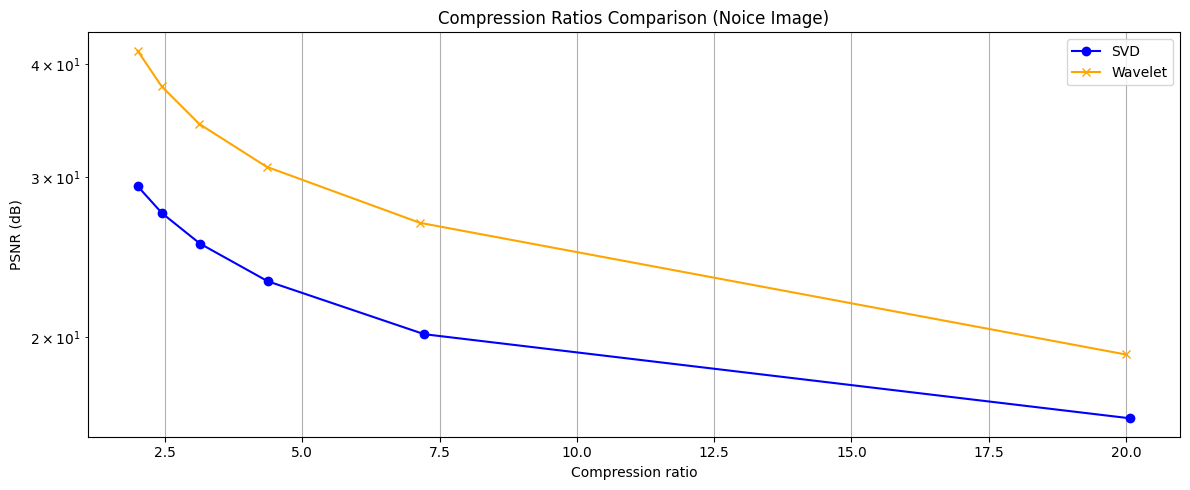

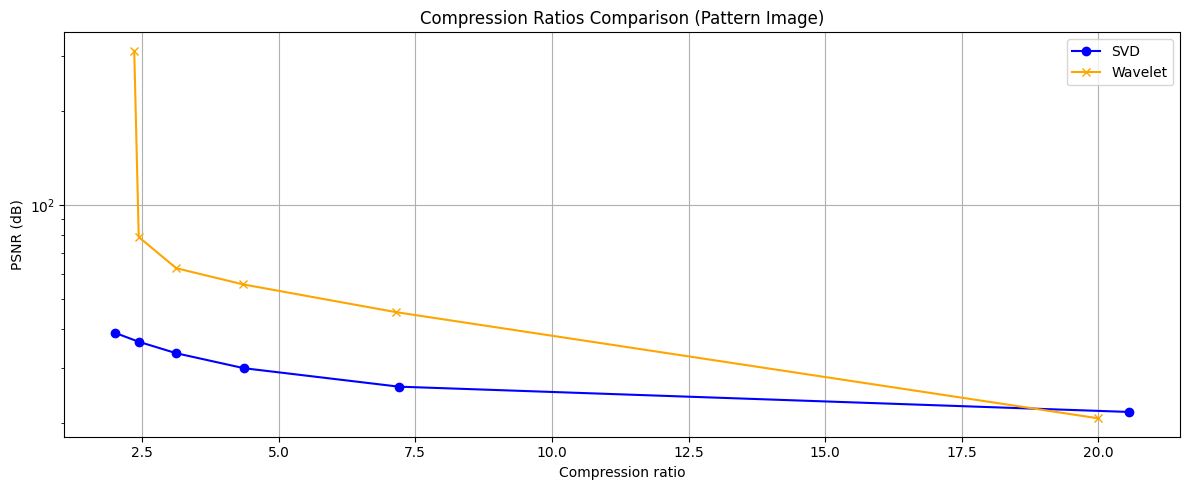

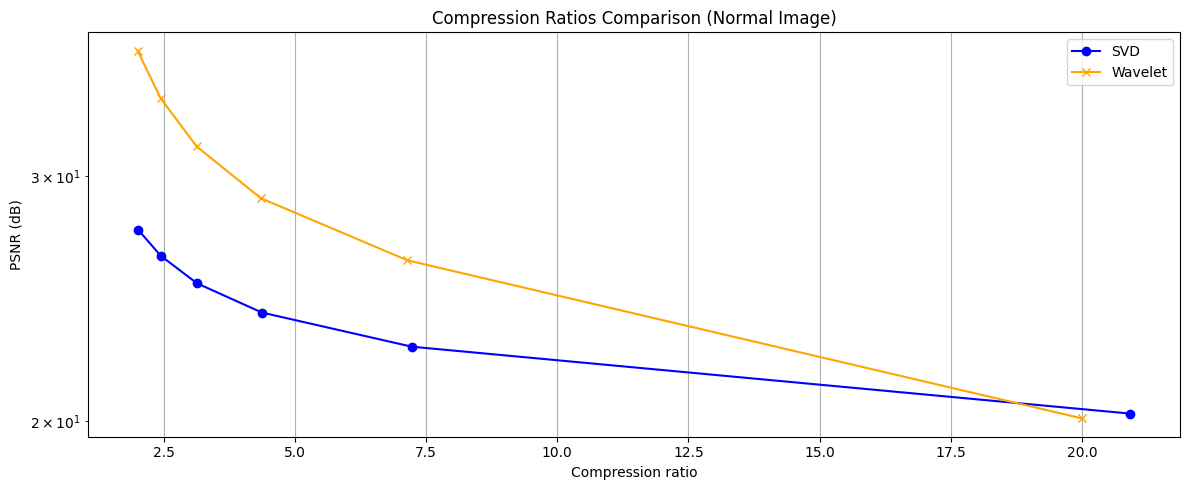

In [483]:
start_idx = 0
# Cyklus pro vykreslení každého obrazu
for idx, image_name in enumerate(image_names):
    fig, axs = plt.subplots(1, 1, figsize=(12, 5))

    # Vypočet správných hranic řezu pro tento obraz (každý obraz má len(keep_ratios) záznamů)
    end_idx = start_idx + len(keep_ratios)
    # VykresleníSVD a Wavelet dat pro aktuální obraz
    x_svd_chunk = compression_ratios_svd[start_idx:end_idx]
    y_svd_chunk = PSNR_SVD[start_idx:end_idx]
    axs.plot(x_svd_chunk, y_svd_chunk, marker='o', color='blue')

    x_wav_chunk = compression_ratios_wavelet[start_idx:end_idx]
    y_wav_chunk = PSNR_Wavelet[start_idx:end_idx]
    axs.plot(x_wav_chunk, y_wav_chunk, marker='x', color='orange')
    # Vlastnosti grafu
    axs.set_ylabel("PSNR (dB)")
    axs.set_yscale('log')
    axs.set_xlabel("Compression ratio")

    axs.set_title(f"Compression Ratios Comparison ({image_names[idx]})")
    axs.grid(True)

    plt.tight_layout()
    plt.legend(['SVD', 'Wavelet'])
    fig.savefig(f'results/{image_name}_psnr_comparison.png', bbox_inches='tight')
    plt.show()

    # Dalsí obraz
    start_idx = end_idx


 Heatmapa 

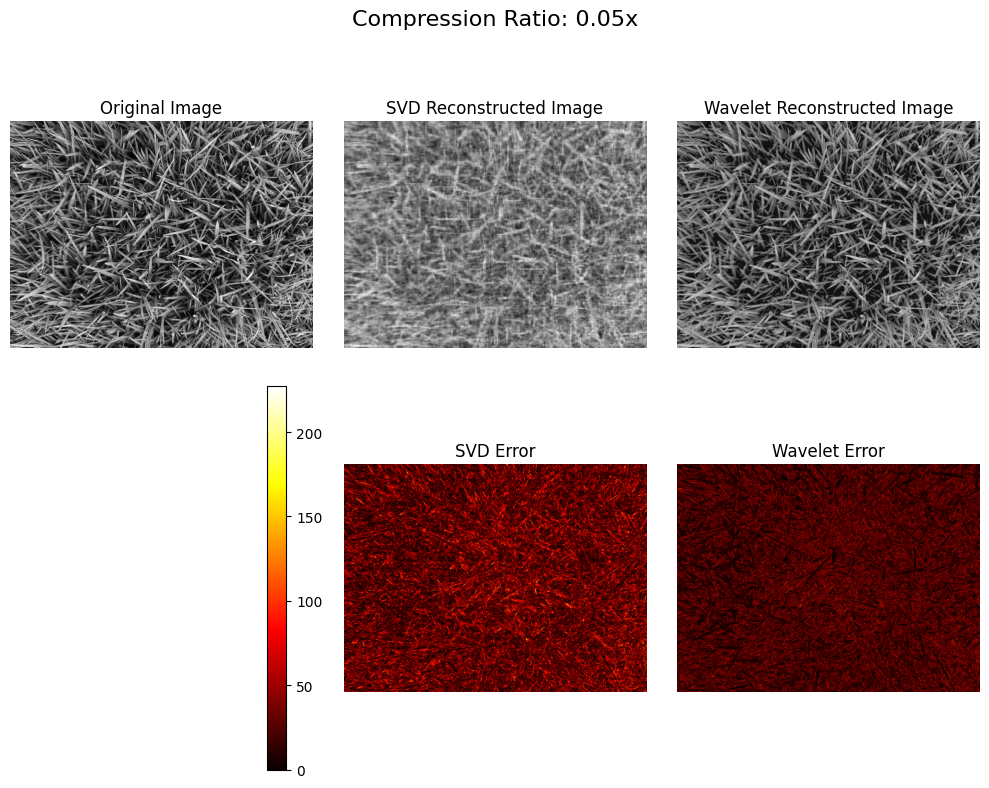

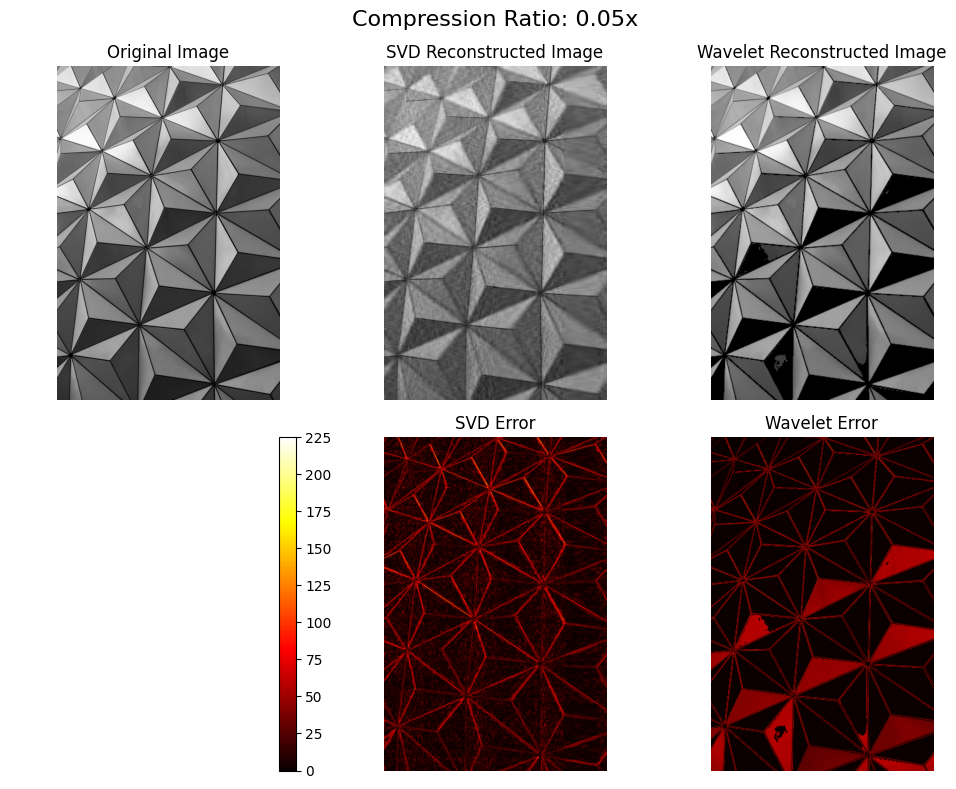

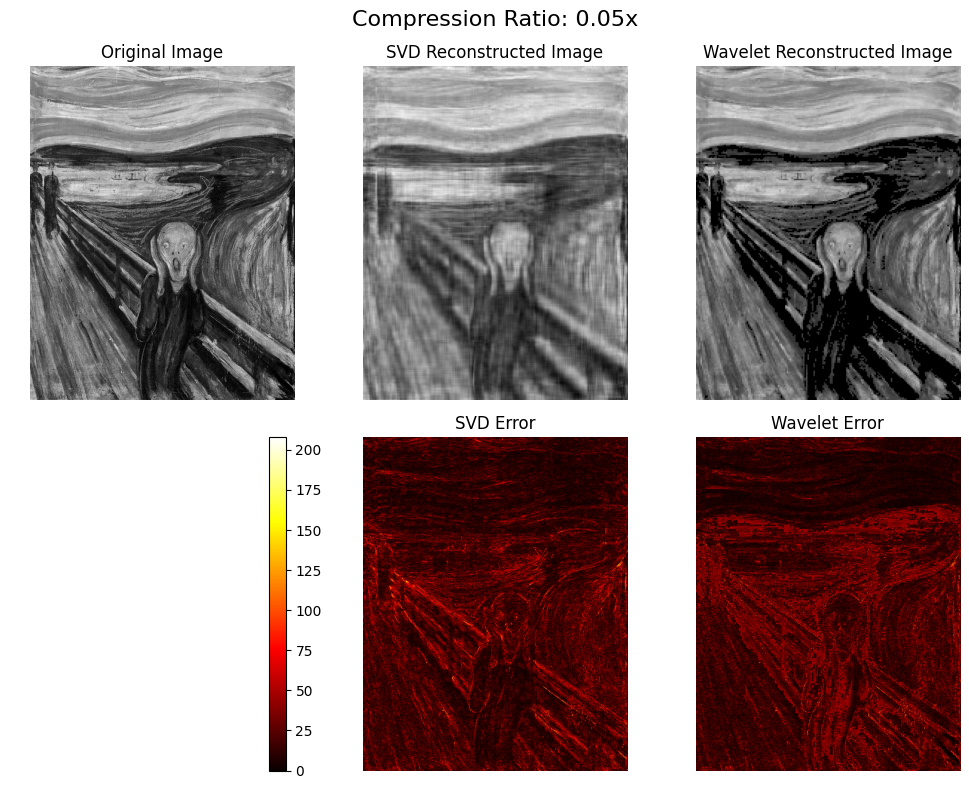

In [484]:

def heatmap_results(original_image, svd_reconstructed, wavelet_reconstructed, ratio, image_name):
    # Vypočet chybových map
    error_svd = np.abs(original_image - svd_reconstructed)
    error_wavelet = np.abs(original_image - wavelet_reconstructed)
    # Maximální hodnota pro škálování barevné mapy
    max_error = max(np.max(error_svd), np.max(error_wavelet))
    fig, axs = plt.subplots(2, 3, figsize=(10, 8))
    fig.suptitle(f'Compression Ratio: {ratio:.2f}x', fontsize=16)
    # Vykreslení obrazu
    axs[0, 0].imshow(original_image, cmap='gray')
    axs[0, 0].set_title('Original Image')
    axs[0, 0].axis('off')

    axs[0, 1].imshow(svd_reconstructed, cmap='gray')
    axs[0, 1].set_title('SVD Reconstructed Image')
    axs[0, 1].axis('off')

    axs[0, 2].imshow(wavelet_reconstructed, cmap='gray')
    axs[0, 2].set_title('Wavelet Reconstructed Image')
    axs[0, 2].axis('off')

    # Vykreslení heatmap
    axs[1, 1].imshow(error_svd, cmap='hot', vmin=0, vmax=max_error)
    axs[1, 1].set_title('SVD Error')
    axs[1, 1].axis('off')

    colormap_Range = axs[1, 2].imshow(error_wavelet, cmap='hot', vmin=0, vmax=max_error)
    axs[1, 2].set_title('Wavelet Error')
    axs[1, 2].axis('off')

    # Přidání legendy pro chybové mapy do levého dolního políčka (zachovat místo pro colorbar)
    fig.colorbar(colormap_Range, ax=axs[1, 0])
    axs[1, 0].axis('off')

    plt.tight_layout()
    fig.savefig(f'results/{image_name}_heatmap.png', bbox_inches='tight')
    plt.show()

# Zvolený kompresní poměr
n = 0
# Seznam originálních obrázků
# Vykreslení heatmap pro zvolený obrázek a kompresní poměr

for image_index in range(len(original_images)):
    # použijeme seznam rekonstruovaných obrázků SVD, ne obecný `reconstructed_images`
    svd_img = reconstructed_images_SVD[n + (image_index * N)]
    wav_img = reconstructed_images_wavelet[n + (image_index * N)]
    heatmap_results(original_images[image_index], svd_img, wav_img, keep_ratios[n], image_names[image_index])
